# Dependencies

In [1]:
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("paper",font_scale=1.2)
import xarray as xr
import pandas as pd
import tqdm
import cmocean
import palettable
from moarpalettes import get_palette

## Matplotlib rcparams setup:
plt.style.use('/home/leachl/Documents/Thesis/ancil/figure-style.mplstyle')
## textwidth of Thesis
textwidth = 5.848611111111111

%matplotlib inline

# Import map and network files

In [2]:
network_df = pd.read_csv('../../bib-info/bib-net.txt',delim_whitespace=True,names=['id0','id1','weight'])
map_df = pd.read_csv('../../bib-info/bib-map.txt',sep='	')

## if you want to preprocess clusters so cluster 10-> are aggregated:
map_df.loc[map_df.cluster.isin((map_df.cluster.value_counts()<10).replace(False,np.nan).dropna().index),'cluster'] = (map_df.cluster.value_counts()<10).replace(False,np.nan).dropna().index.min()

## preprocess names to be capitalized
def format_name(name):
    split = name.split(',')
    sn = split[0].strip()
    if len(split)==2:
        ini = split[1].strip()
    else:
        ini=''
        
    return ini.upper()+' '+sn.capitalize()

map_df['label'] = map_df.label.map(format_name)

1687it [00:03, 430.26it/s]


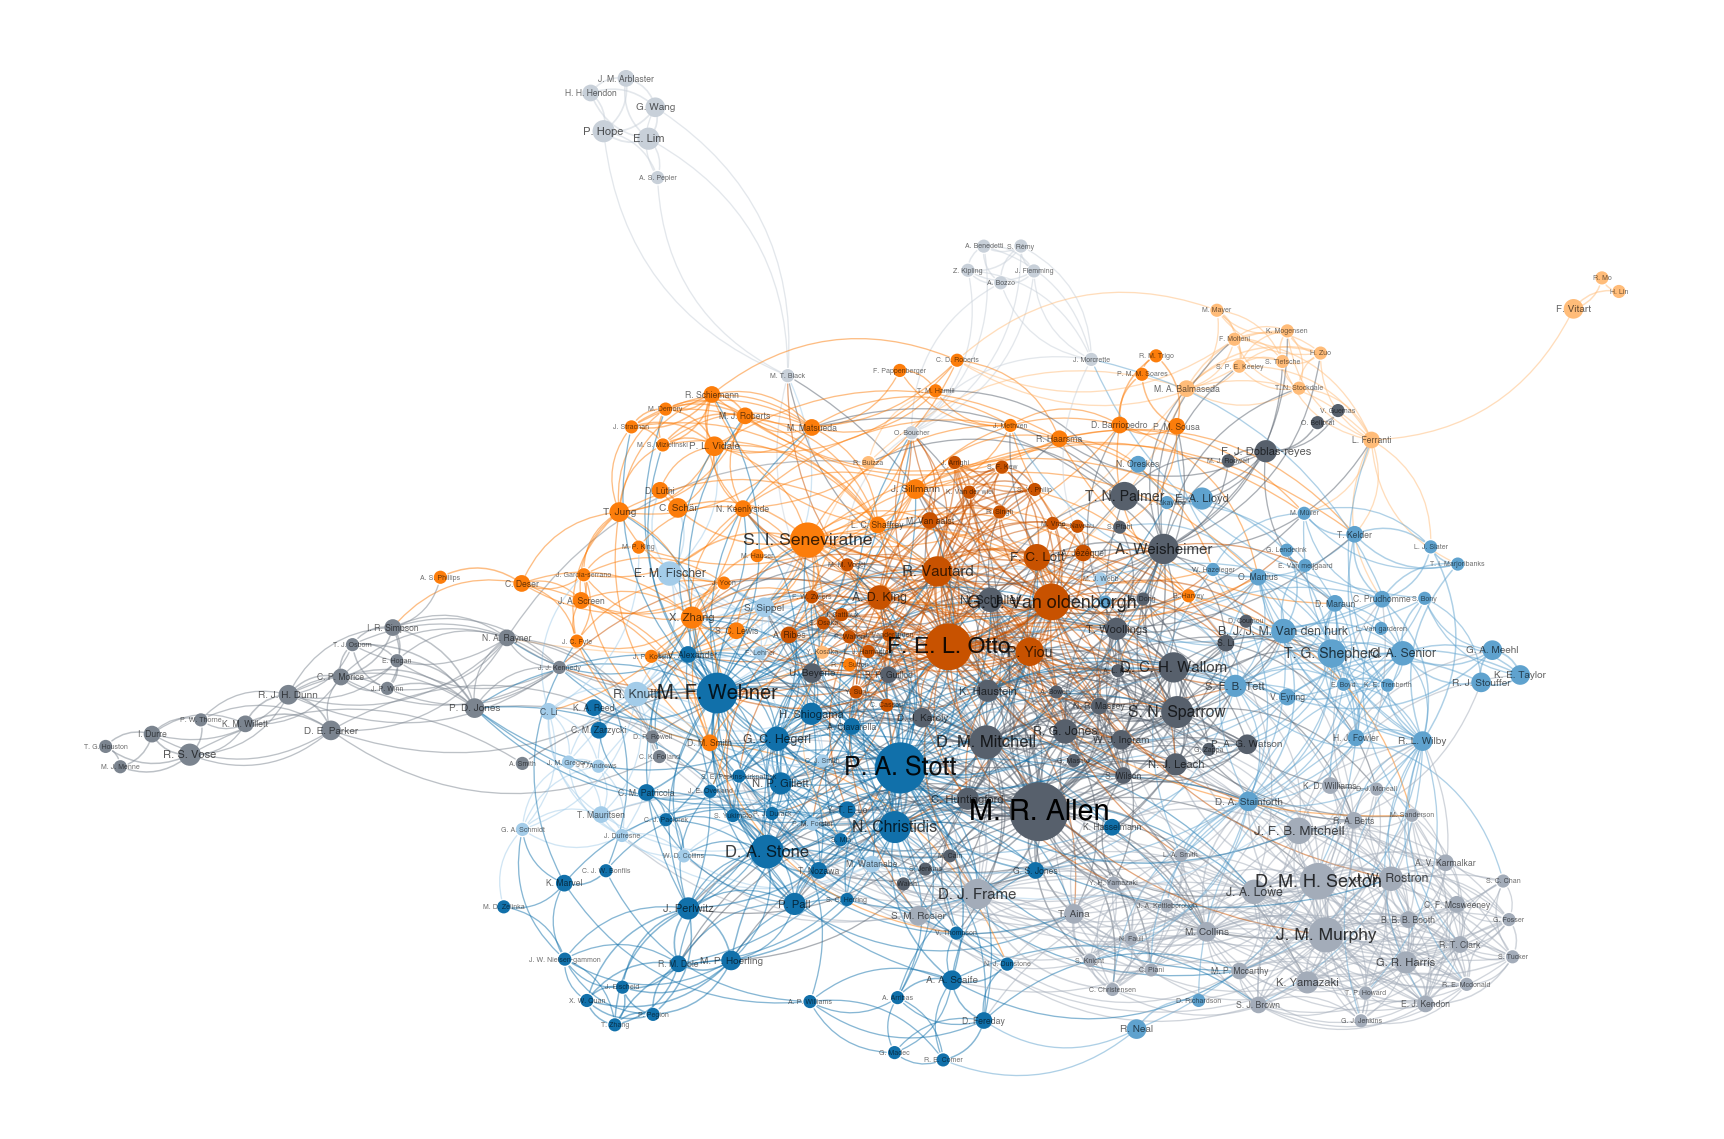

In [3]:
palette = get_palette.color_blind().to_sn_palette()[:10]

fig=plt.figure()

g=sn.scatterplot(data=map_df,x='x',y='y',hue='cluster',size='weight<Documents>',sizes=(10,200),linewidth=0,edgecolors='white',palette=palette,legend=False,alpha=1)

## add circle round your name
# g.axes.plot(*map_df.query('label=="N. J. Leach"').loc[:,('x','y')].values.T,'ok',mfc='none',mew=0.5,ms=14)

g.axes.axis('off')

## add names
for i,s in map_df.iterrows():
    g.axes.annotate(s.label,(s.x,s.y),fontsize=np.sqrt(s['weight<Documents>'])*1.2,ha='center',va='center',alpha=np.sqrt(s['weight<Documents>'] / map_df['weight<Documents>'].max())*0.6 + 0.4)
    
## add lines
pos=True
n_link = 1000
network_idx = network_df.apply(lambda x: map_df.loc[map_df.id.isin([x.id0,x.id1]),'weight<Total link strength>'].sum(),axis=1).sort_values(ascending=False).index[:n_link]
for i,(id0,id1,w) in tqdm.tqdm(network_df.iterrows()):
    
    _df = map_df.loc[map_df.id.isin([id0,id1]),['x','y','cluster','weight<Documents>']]
    
    x = _df.x.values
    y = _df.y.values
    posA = (x[0],y[0])
    posB = (x[1],y[1])
    
    cluster = _df.cluster.loc[_df['weight<Documents>'].idxmax()]
    
    patch = matplotlib.patches.FancyArrowPatch(posA,posB,arrowstyle='-',connectionstyle='arc3,rad='+pos*'-'+'0.3',lw=0.5*(w/network_df.weight.max())**(1/5),alpha=0.5,color=palette[cluster-1],zorder=-1)
    g.axes.add_patch(patch)
    
    pos = not pos

## figure layout
fig.dpi=300
fig_aspect = 2/3
fig.set_size_inches(textwidth,textwidth*fig_aspect)
fig.patch.set_facecolor((0,0,0,0))
plt.tight_layout()

## save
# [fig.savefig('./FigI.network.'+x,dpi=600) for x in ['png','pdf']]